# Net Liquidity

#### This notebook will reveal what Net Liquidity is and how it is calculated. It will show how Net Liquidity has changed over time, as well as how it leads the market ($SPX). 
*All credit for this work is attributed to @dharmafi*

$$Net Liquidity = Federal Reserve Balance sheet - Treasury General Account - Reverse Repo$$

### Introduction

Net Liquidity measures the amount of money actually available to circulate in the economy from the Federal Reserve. This value calculates the amount of the Federal Reserve's balance sheet that is available to circulate in the economy and the markets through quantitative easing (QE). Each shift in Net Liquidity takes 2 weeks to reveal itself in the SPX, making it a 2 week leading indicator. It is calculated as the Federal Reserve Balance Sheet (WALCL) minus the amount of money in Reverse Repurchase Agreements (RRP) minus the amount in the Tresury General Account (TGA). In this notebook we will grab the value of Net Liquidity through 3 APIs, and place it in a dataframe. We will plot it and compare its value to the SPX over the past two years.


### Setup
Import necessary libraries

In [219]:
import requests
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from io import StringIO
import yfinance as yf




Download the TGA data from the treasury.gov API and covert it into a dataframe.
This value is updated daily at 4 PM EST and is for the previous day.

In [220]:
tgaResponse = requests.get("https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/dts/dts_table_1?filter=record_date:gte:2015-01-01,account_type:eq:Treasury General Account (TGA) Opening Balance&fields=record_date,open_today_bal&page[number]=1&page[size]=3000&format=csv")
df_tga = pd.read_csv(StringIO(tgaResponse.text))
df_tga = df_tga.rename(columns = {'record_date':'Date', 'open_today_bal':'Amount'})
tgaResponse2 = requests.get('https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/dts/dts_table_1?filter=account_type:eq:Treasury General Account (TGA)&fields=open_today_bal,record_date&page[size]=1000&page[number]=1&format=csv')
df_tga2 = pd.read_csv(StringIO(tgaResponse2.text))
df_tga2 = df_tga2.rename(columns = {'record_date':'Date', 'open_today_bal':'Amount'})
tgaData = {
    'Date': ['2022-03-02', '2022-03-03','2022-03-04','2022-03-07','2022-03-08','2022-03-09','2022-03-10','2022-03-11','2022-03-14','2022-03-15','2022-03-16','2022-03-17','2022-03-18','2022-03-21','2022-03-22','2022-03-23','2022-03-24','2022-03-25','2022-03-28','2022-03-29','2022-03-30','2022-03-31','2022-04-01','2022-04-04','2022-04-05','2022-04-06','2022-04-07','2022-04-08','2022-04-11','2022-04-12','2022-04-13','2022-04-14','2022-04-15'], 'Amount': [699674,685491,661486,658241,673387,645312,609369,541965,544592,567360,629614,621527,624216,622418,626636,607762,576442,563796,582578,596168,560968,556791,651523,567423,579607,542176,545584,542946,544736,564856,545611,543536,602292]
}
df_tgaData = pd.DataFrame(tgaData)
df_tga2 = pd.concat([df_tga2,df_tgaData], ignore_index=True)
df_tga = pd.concat([df_tga2,df_tga], ignore_index=True)
#Multiply for actual dollar amount
df_tga['Amount'] = df_tga['Amount']*1000000


Download the WALCL data from the Federal Reserve Economic Data (FRED) API and covert it into a dataframe.
This value is updated weekly at 4:30 PM EST each Thursday.

In [221]:
walclResponse = requests.get("https://fred.stlouisfed.org/graph/fredgraph.csv?id=WALCL")
df_walcl = pd.read_csv(StringIO(walclResponse.text))
df_walcl = df_walcl.rename(columns = {'DATE':'Date', 'WALCL':'Amount'})


Download the RRP data from the Federal Reserve Bank of New York API and covert it into a dataframe.
This value is updated daily at 1:15 PM EST.

In [222]:
today = str(date.today())
rrpResponse = requests.get("https://markets.newyorkfed.org/api/rp/reverserepo/propositions/search.csv?startDate=2003-01-01&endDate="+today)
df_rrp = pd.read_csv(StringIO(rrpResponse.text))
df_rrp = df_rrp.drop(['Operation Id', 'Operation Type','Note','Bank Prop Amt Accepted ($Billions)','GSE Prop Amt Accepted ($Billions)','MMF Prop Amt Accepted ($Billions)','PD Prop Amt Accepted ($Billions)'], axis=1)
df_rrp = df_rrp.rename(columns = {'Operation Date':'Date', 'Total Amt Accepted ($Billions)':'Amount'})
#Multiply for actual dollar amount
df_rrp['Amount'] = df_rrp['Amount']*1000000000
df_rrp = df_rrp[::-1].reset_index(drop=True)

## Graphing Each Variable in Net Liquidity Over 2 Years

Clean dataframes and convert to datetime

In [223]:
df_walcl['Date'] = pd.to_datetime(df_walcl['Date'])
df_tga['Date'] = pd.to_datetime(df_tga['Date'])
df_rrp['Date'] = pd.to_datetime(df_rrp['Date'])

df_walcl.set_index('Date', inplace=True)
df_tga.set_index('Date', inplace=True)
df_rrp.set_index('Date', inplace=True)


In [224]:
combined_df = df_rrp.add(df_tga, fill_value=0)
combined_df, df_walcl = combined_df.align(df_walcl, fill_value=0)
df_walcl = df_walcl.reindex(combined_df.index)
df_walcl.replace(0, method='ffill', inplace=True)
df_walcl = df_walcl.reindex(combined_df.index)
df_walcl['Amount'] = df_walcl['Amount']*1000000
df_netliq = df_walcl.sub(combined_df, fill_value=0)
#Hardcode values to account for wonky APIs dating
df_netliq['Amount'].mask(df_netliq['Amount'] == 8.613581e+12, 7.029044e+12, inplace=True)
df_netliq['Amount'].mask(df_netliq['Amount'] == 8.363195e+12, 6.664599e+12, inplace=True)
df_netliq['Amount'].mask(df_netliq['Amount'] == 8.519419e+12, 6.300044e+12, inplace=True)
df_netliq['Amount'].mask(df_netliq['Amount'] == 8.153435e+12, 6.039090e+12, inplace=True)


#### WALCL Graph

[Text(0.5, 1.0, 'WALCL Value')]

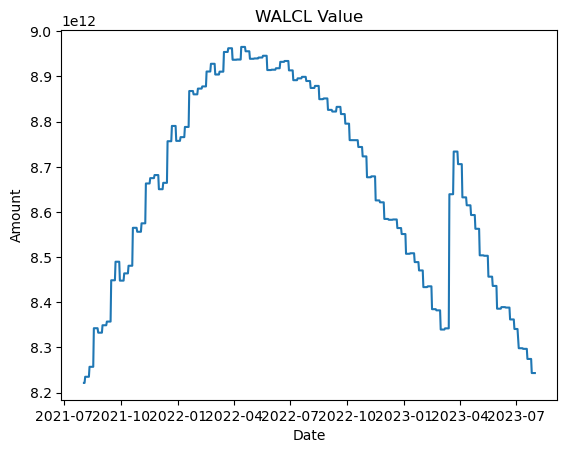

In [225]:
df_walcl2 = df_walcl[df_walcl.index >= (df_walcl.index.max() - pd.DateOffset(years=2))]
sns.lineplot(data=df_walcl2,x="Date",y="Amount").set(title='WALCL Value')

#### TGA Graph

[Text(0.5, 1.0, 'TGA Value')]

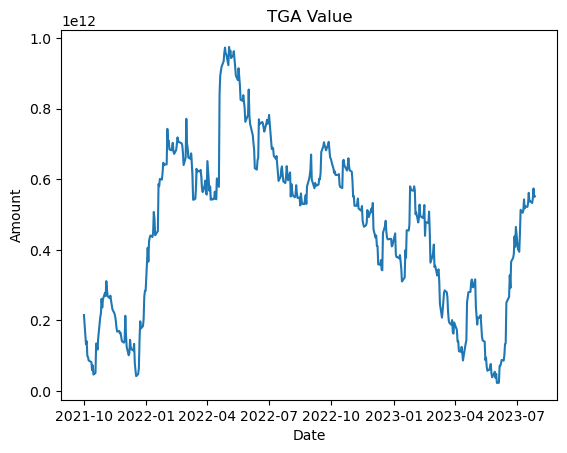

In [226]:
df_tga2 = df_tga[df_tga.index >= (df_tga.index.max() - pd.DateOffset(years=2))]
sns.lineplot(data=df_tga2,x="Date",y="Amount").set(title='TGA Value')

#### RRP Graph

[Text(0.5, 1.0, 'RRP Value')]

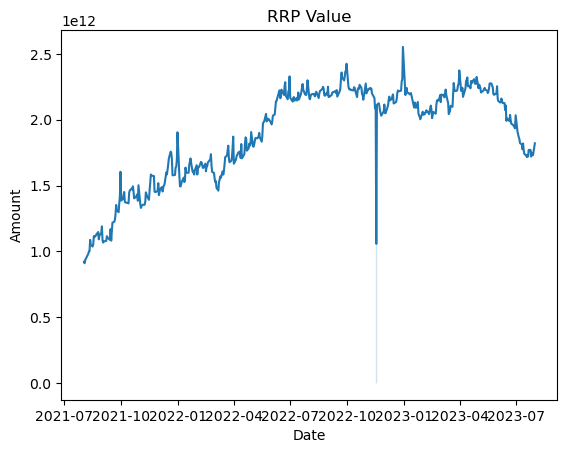

In [227]:
df_rrp2 = df_rrp[df_rrp.index >= (df_rrp.index.max() - pd.DateOffset(years=2))]
sns.lineplot(data=df_rrp2,x="Date",y="Amount").set(title='RRP Value')

In [228]:
df_netliq.tail()

,Amount
Date,
2023-07-25,6.008822e+12
2023-07-26,5.919713e+12
2023-07-27,5.957664e+12
2023-07-28,5.961486e+12
2023-07-31,6.422220e+12


[Text(0.5, 1.0, 'Net Liquidity Value')]

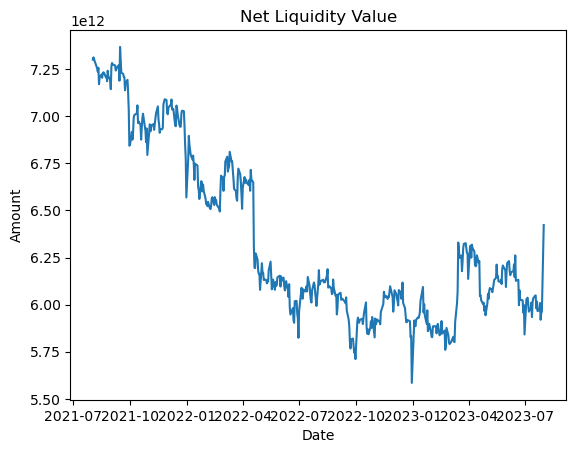

In [229]:
df_net2 = df_netliq[df_netliq.index >= (df_netliq.index.max() - pd.DateOffset(years=2))]
sns.lineplot(data=df_net2,x=df_net2.index,y="Amount").set(title='Net Liquidity Value')


[*********************100%***********************]  1 of 1 completed


[Text(0.5, 1.0, 'Last 2 Years of S&P 500 Closing Prices')]

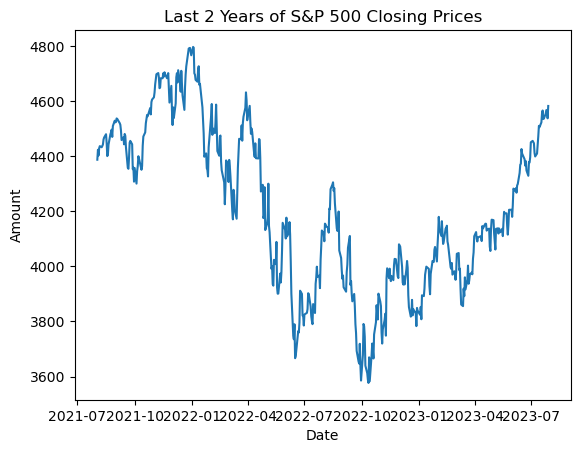

In [230]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365 * 2)
spx_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
spx_df = pd.DataFrame(spx_data)
spx_df.index.name = 'Date'
spx_df = spx_df.rename(columns = {'Adj Close':'Amount'})
sns.lineplot(data=spx_df,x=spx_df.index,y='Amount').set(title='Last 2 Years of S&P 500 Closing Prices')

In [231]:
print(df_net2.to_string())


                  Amount
Date                    
2021-08-02  7.300156e+12
2021-08-03  7.312031e+12
2021-08-04  7.303318e+12
2021-08-05  7.290738e+12
2021-08-06  7.282939e+12
2021-08-09  7.253308e+12
2021-08-10  7.236419e+12
2021-08-11  7.256699e+12
2021-08-12  7.169817e+12
2021-08-13  7.206218e+12
2021-08-16  7.220741e+12
2021-08-17  7.203705e+12
2021-08-18  7.226942e+12
2021-08-19  7.232660e+12
2021-08-20  7.230693e+12
2021-08-23  7.206901e+12
2021-08-24  7.212861e+12
2021-08-25  7.185654e+12
2021-08-26  7.240951e+12
2021-08-27  7.212728e+12
2021-08-30  7.192032e+12
2021-08-31  7.143127e+12
2021-09-01  7.265058e+12
2021-09-02  7.282186e+12
2021-09-03  7.274466e+12
2021-09-07  7.269228e+12
2021-09-08  7.242085e+12
2021-09-09  7.249655e+12
2021-09-10  7.257991e+12
2021-09-13  7.270206e+12
2021-09-14  7.188034e+12
2021-09-15  7.367428e+12
2021-09-16  7.301276e+12
2021-09-17  7.230467e+12
2021-09-20  7.224481e+12
2021-09-21  7.208276e+12
2021-09-22  7.206543e+12
2021-09-23  7.137341e+12
